# Proceso de deteccion de cambios en la superficie

### Primero se importan las librerias que serán necesarias para todo el procesamiento

In [1]:
import numpy as np
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.transform import from_origin 
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
%matplotlib inline

### Se cargan los archivos con la informacion geografica de los deslizamientos y las imagenes GeoTIFF

In [2]:
# shape_puntos -> Contiene informacion de los deslizamientyos de tierra en la provincia de Huamanga
# Shape_area   -> Multipoligono con el area de la  provincia de Huamanga
shape_puntos  = gpd.read_file('../shapefileOutput/puntosSeleccionados/REGP.shp')
shape_area    = gpd.read_file('../shapefileOutput/regionSeleccionada/REGS.shp')
tiff_satelite = rio.open('../imageInput/LC08_L1TP_005069_20190806_20190820_01_T1/LC08_L1TP_005069_20190806_20190820_01_T1_B4.TIF')
tiff_satelite_2015 = rio.open('../imageInput/LC08_L1TP_005069_20150710_20170407_01_T1/LC08_L1TP_005069_20150710_20170407_01_T1_B4.TIF')

In [3]:
print(tiff_satelite.transform)
print(tiff_satelite_2015.transform)
print(tiff_satelite_2015.transform*(80,0))

| 30.00, 0.00, 542985.00|
| 0.00,-30.00,-1322685.00|
| 0.00, 0.00, 1.00|
| 30.00, 0.00, 540585.00|
| 0.00,-30.00,-1322685.00|
| 0.00, 0.00, 1.00|
(542985.0, -1322685.0)


### Se selecciona un area de 300 x 600 px de la imagen GeoTIFF original

In [4]:
# bounds_tiff  -> Cordenadas geograficas de los limites de la imagen GeoTIFF
bounds_tiff = tiff_satelite.bounds
tiff_satelite.close()
bounds_tiff

BoundingBox(left=542985.0, bottom=-1556115.0, right=772515.0, top=-1322685.0)

In [5]:
# left, top    -> Coordenadas geografica de la esquina superior izquierda de la imagen GeoTIFF
# px_x0, px_y0 -> Coordenada del pixel superior izquierdo del nuevo cuadro dentro de GeoTIFF
# w, h         -> Ancho y alto en pixeles del nuevo cuadro

def create_box(left, top, px_x0, px_y0, w, h):
    '''
        El cuadro nuevo se crea con limites geograficos, 
        entonces convertimos los pixeles a ubicaciones geograficas.
    '''
    x0 = left + (px_x0 * 30) # 30 metros es la resolucion espacial de cada pixel
    y0 = top  - (px_y0 * 30)
    xn = x0   + (w * 30)
    yn = y0   - (h * 30)
    p1 = Polygon([(x0, y0), (x0, yn), (xn, yn), (xn, y0)])
    box = gpd.GeoDataFrame(index=[0], geometry = [p1], crs = shape_area.crs)
    return box

In [6]:
# Creamos un cuadro nuevo que empieza en el pixel 1000, 4200 del GeoTiff y tiene un tamaño de 300x600

# box -> Contiene el cuadro nuevo

box = create_box(bounds_tiff.left, bounds_tiff.top, 1000, 4200, 600, 300) # Solo es necesario ejecutarlo la primera vez
box.to_file("../shapefileOutput/box_1/box.shp") # Solo es necesario ejecutarlo la primera vez
box           = gpd.read_file("../shapefileOutput/box_1/box.shp")

### Se realiza la seleccion de los deslizamientos que estan dentro del nuevo cuadro

In [7]:
# box_punt   -> Contiene los puntos donde ocurrienron deslizamientosy que estan dentro del nuevo cuadro

box_punt = gpd.GeoDataFrame(shape_puntos[shape_puntos.intersects(box.unary_union)], crs = shape_area.crs)# Solo es necesario ejecutarlo la primera vez
box_punt.to_file("../shapefileOutput/box_punt_1/box_punt.shp")# Solo es necesario ejecutarlo la primera vez
box_punt      = gpd.read_file("../shapefileOutput/box_punt_1/box_punt.shp")

### Lo observavos en graficos

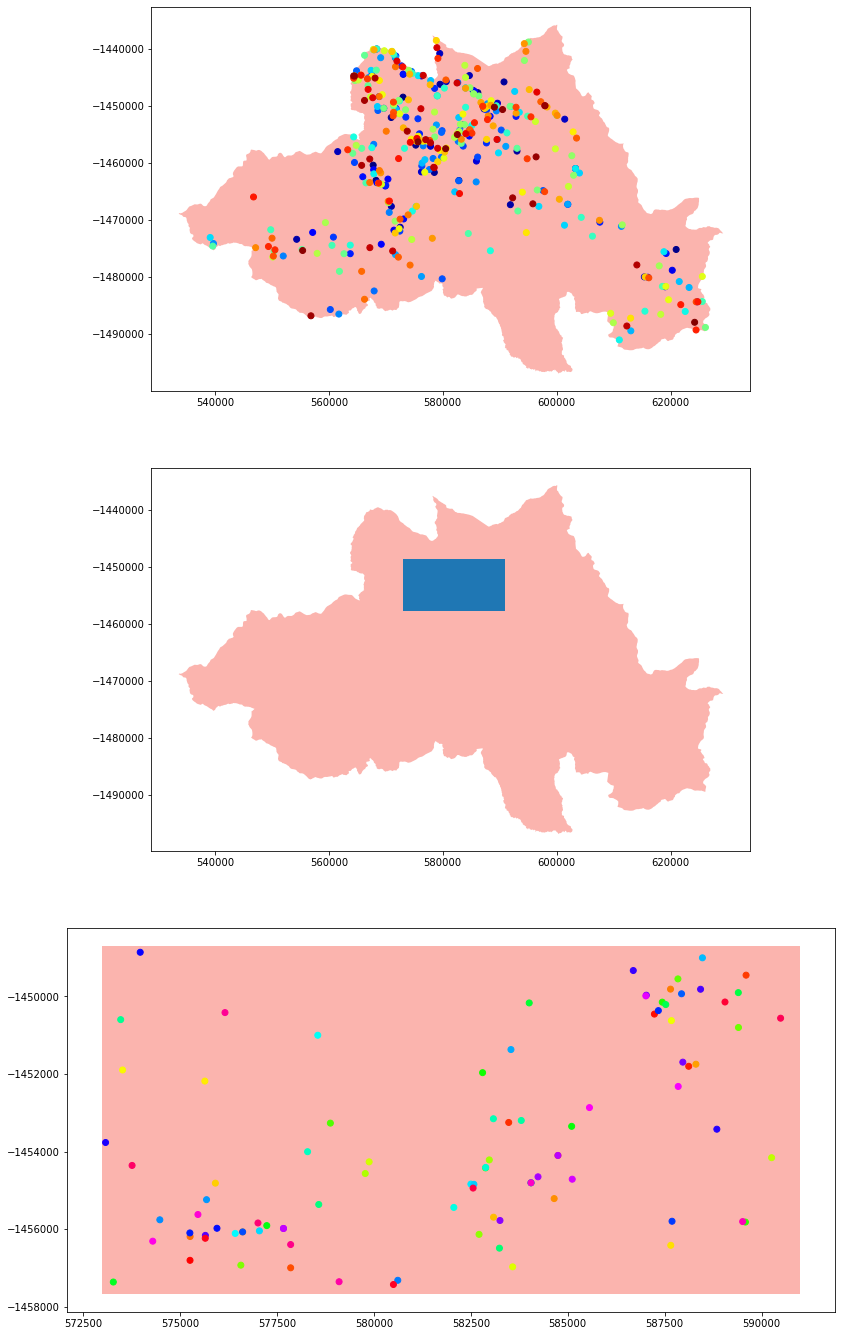

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 24))
shape_area.plot(ax=ax1, cmap = 'Pastel1')
shape_puntos.plot(ax=ax1, cmap = 'jet')
shape_area.plot(ax=ax2, cmap = 'Pastel1')
box.plot(ax = ax2)
box.plot(ax=ax3, cmap = 'Pastel1')
box_punt.plot(ax=ax3, cmap = 'hsv')
plt.show()

### Ahora se realizaran los cortes de las Imagenes GeoTIFF

Se define la funcion con la que se cortara banda a banda

In [9]:
# path_image  -> URL de la imagen a recortar
# px_x0, px_y0 -> Coordenada del pixel superior izquierdo del nuevo cuadro dentro de GeoTIFF
# w, h         -> Ancho y alto en pixeles del nuevo cuadro

def cut_tiff(path_image, px_x0, px_y0, w, h):
    imager = rio.open(path_image)
    image = imager.read(1)
    new_image = image[px_y0:px_y0+h, px_x0:px_x0+w]
    l, t = imager.transform * (px_x0, px_y0)
    newTransform = from_origin(l, t, 30, 30)
    new_src = rio.open(
    '../imageOutput/cut/cut_'+path_image[-47:],
    'w',
    driver='GTiff',
    height=h,
    width=w,
    count=1,
    dtype='uint16',
    crs='EPSG:32618',
    transform=newTransform,
    )
    new_src.write(new_image, 1)
    new_src.close()
    imager.close()

Realizamos en corte de la banda azul(B2), verde(B3), rojo(B4) e infrarojo cercano(B5) de la imagen

In [10]:
cut_tiff('../imageInput/LC08_L1TP_005069_20190806_20190820_01_T1/LC08_L1TP_005069_20190806_20190820_01_T1_B2.TIF', 1000, 4200, 600, 300)
cut_tiff('../imageInput/LC08_L1TP_005069_20190806_20190820_01_T1/LC08_L1TP_005069_20190806_20190820_01_T1_B3.TIF', 1000, 4200, 600, 300)
cut_tiff('../imageInput/LC08_L1TP_005069_20190806_20190820_01_T1/LC08_L1TP_005069_20190806_20190820_01_T1_B4.TIF', 1000, 4200, 600, 300)
cut_tiff('../imageInput/LC08_L1TP_005069_20190806_20190820_01_T1/LC08_L1TP_005069_20190806_20190820_01_T1_B5.TIF', 1000, 4200, 600, 300)

cut_tiff('../imageInput/LC08_L1TP_005069_20150710_20170407_01_T1/LC08_L1TP_005069_20150710_20170407_01_T1_B2.TIF', 1080, 4200, 600, 300)
cut_tiff('../imageInput/LC08_L1TP_005069_20150710_20170407_01_T1/LC08_L1TP_005069_20150710_20170407_01_T1_B3.TIF', 1080, 4200, 600, 300)
cut_tiff('../imageInput/LC08_L1TP_005069_20150710_20170407_01_T1/LC08_L1TP_005069_20150710_20170407_01_T1_B4.TIF', 1080, 4200, 600, 300)
cut_tiff('../imageInput/LC08_L1TP_005069_20150710_20170407_01_T1/LC08_L1TP_005069_20150710_20170407_01_T1_B5.TIF', 1080, 4200, 600, 300)

In [11]:
imagen19_2 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20190806_20190820_01_T1_B2.TIF')
imagen19_3 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20190806_20190820_01_T1_B3.TIF')
imagen19_4 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20190806_20190820_01_T1_B4.TIF')
imagen19_5 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20190806_20190820_01_T1_B5.TIF')

imagen15_2 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20150710_20170407_01_T1_B2.TIF')
imagen15_3 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20150710_20170407_01_T1_B3.TIF')
imagen15_4 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20150710_20170407_01_T1_B4.TIF')
imagen15_5 = rio.open('../imageOutput/cut/cut_LC08_L1TP_005069_20150710_20170407_01_T1_B5.TIF')

In [12]:
nir19  = imagen19_5.read(1).astype('float64')
red19  = imagen19_4.read(1).astype('float64')
ndvi19 = (nir19 - red19)/(nir19 + red19)

nir15  = imagen15_5.read(1).astype('float64')
red15  = imagen15_4.read(1).astype('float64')
ndvi15 = (nir15 - red15)/(nir15 + red15)

In [13]:
gray19 = (imagen19_2.read(1).astype('float64') + imagen19_3.read(1).astype('float64') + imagen19_4.read(1).astype('float64'))/3
gray15 = (imagen15_2.read(1).astype('float64') + imagen15_3.read(1).astype('float64') + imagen15_4.read(1).astype('float64'))/3

In [14]:
grayN19 = (gray19 - gray19.min())/(gray19.max() - gray19.min())
grayN15 = (gray15 - gray15.min())/(gray15.max() - gray15.min())

In [15]:
def areas(image, data=np.array([0])):
    A = []
    x = box_punt.geometry
    if data.size == 1:
        data = image.read(1)
    for i, c in enumerate(x):
        row, col = image.index(c.x, c.y)
        if(row > 4 and col > 4):
            A.append(data[row-5:row+6, col-5:col+6])
    return A

In [16]:
A2 = areas(imagen19_2)
A3 = areas(imagen19_3)
A4 = areas(imagen19_4)
A5 = areas(imagen19_5)
Andvi  = areas(imagen19_2, ndvi19)
AgrayN = areas(imagen19_2, grayN19)

B2 = areas(imagen15_2)
B3 = areas(imagen15_3)
B4 = areas(imagen15_4)
B5 = areas(imagen15_5)
Bndvi  = areas(imagen19_2, ndvi15)
BgrayN = areas(imagen19_2, grayN15)

len(B2)

94

In [17]:
def areas_random(image, xs, ys, data = np.array([0])):
    A = []
    if data.size == 1:
        data = image.read(1)
    for i in range(len(xs)):
        A.append(data[ys[i]-5:ys[i]+6, xs[i]-5:xs[i]+6])
    return A

In [18]:
xs = np.random.randint(10, 590, size=len(A2))
ys = np.random.randint(10, 290, size=len(A2))

A2_r = areas_random(imagen19_2, xs, ys)
A3_r = areas_random(imagen19_3, xs, ys)
A4_r = areas_random(imagen19_4, xs, ys)
A5_r = areas_random(imagen19_5, xs, ys)
Andvi_r  = areas_random(imagen19_2, xs, ys, ndvi19)
AgrayN_r = areas_random(imagen19_2, xs, ys, grayN19)

B2_r = areas_random(imagen15_2, xs, ys)
B3_r = areas_random(imagen15_3, xs, ys)
B4_r = areas_random(imagen15_4, xs, ys)
B5_r = areas_random(imagen15_5, xs, ys)
Bndvi_r  = areas_random(imagen19_2, xs, ys, ndvi15)
BgrayN_r = areas_random(imagen19_2, xs, ys, grayN15)

In [19]:
len(B2_r)

94

In [40]:
Cgray_r = []
for i in range(len(A2)):
    Cgray_r.append(AgrayN_r[i] - BgrayN_r[i])
Cgray = []
for i in range(len(A2)):
    Cgray.append(AgrayN[i] - BgrayN[i])
    
Cndvi_r = []
for i in range(len(A2)):
    Cndvi_r.append(Andvi_r[i] - Bndvi_r[i])
Cndvi = []
for i in range(len(A2)):
    Cndvi.append(Andvi[i] - Bndvi[i])

## Muestras de imagen donde si hubo deslizamientos

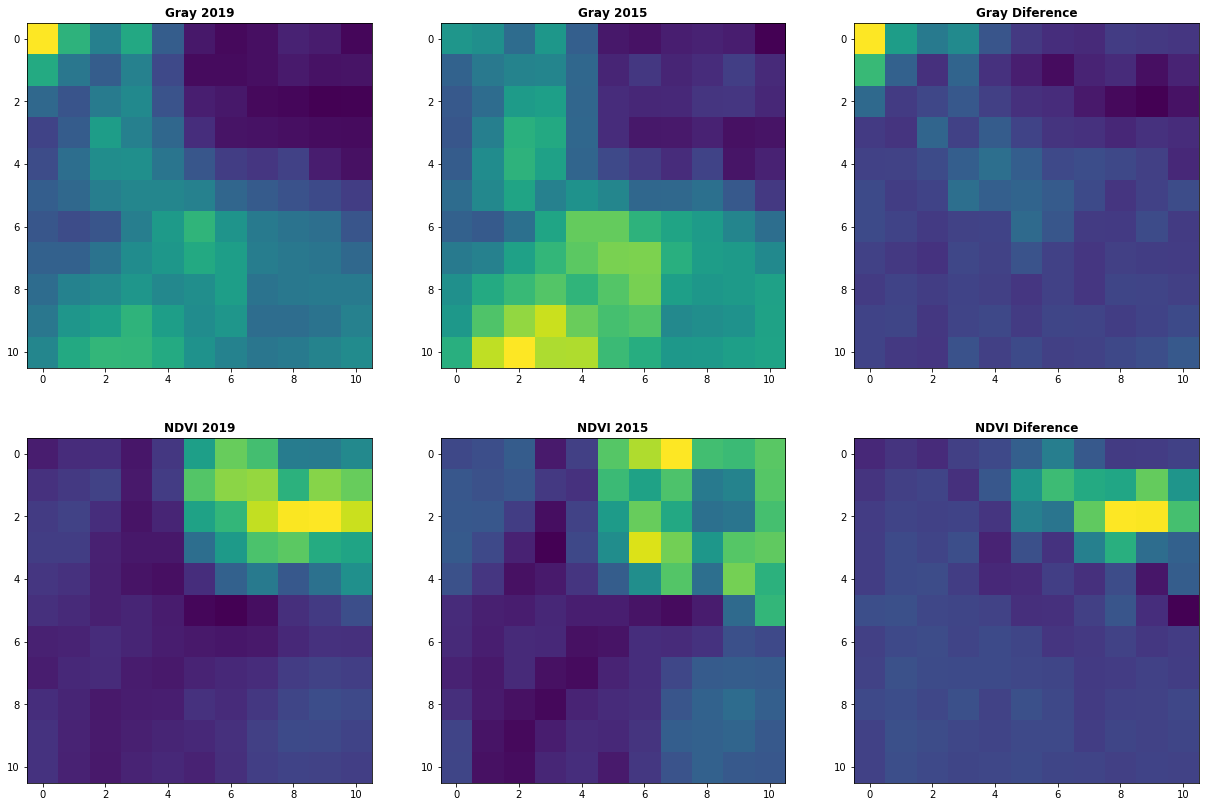

In [49]:
muestra = 1 # 2 de 94
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(21, 14))
rioplt.show(AgrayN[muestra], ax=ax1, title='Gray 2019')
rioplt.show(BgrayN[muestra], ax=ax2, title='Gray 2015')
rioplt.show(Cgray[muestra], ax=ax3, title='Gray Diference')
rioplt.show(Andvi[muestra], ax=ax4, title='NDVI 2019')
rioplt.show(Bndvi[muestra], ax=ax5, title='NDVI 2015')
rioplt.show(Cndvi[muestra], ax=ax6, title='NDVI Diference')
plt.show()

## Muestras de imagen donde no hubo deslizamientos

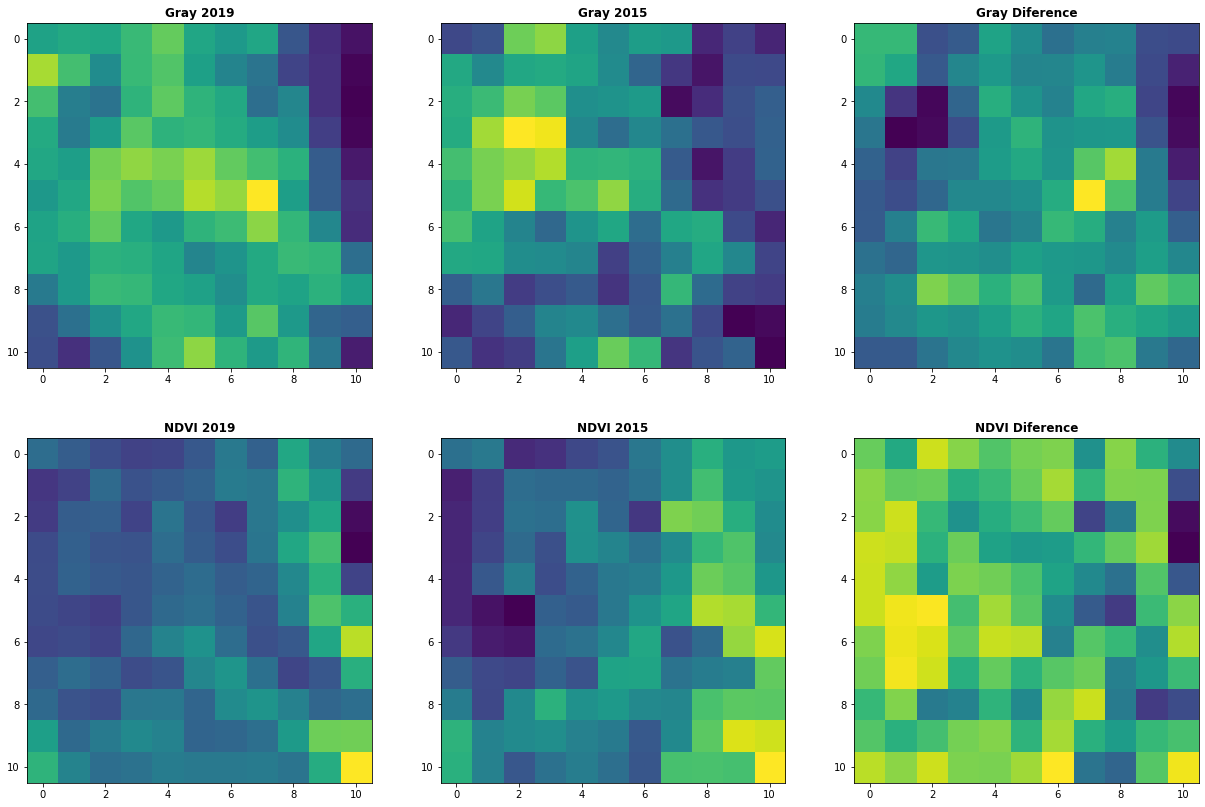

In [50]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(21, 14))
rioplt.show(AgrayN_r[muestra], ax=ax1, title='Gray 2019')
rioplt.show(BgrayN_r[muestra], ax=ax2, title='Gray 2015')
rioplt.show(Cgray_r[muestra], ax=ax3, title='Gray Diference')
rioplt.show(Andvi_r[muestra], ax=ax4, title='NDVI 2019')
rioplt.show(Bndvi_r[muestra], ax=ax5, title='NDVI 2015')
rioplt.show(Cndvi_r[muestra], ax=ax6, title='NDVI Diference')
plt.show()